In [1]:
using Pkg
# Pkg.activate("../../")
Pkg.activate("../../", io=devnull)
Pkg.update(io=devnull)

In [2]:
using VeryDiff
using LinearAlgebra
using Plots
using Plots.PlotMeasures

include("../util.jl")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2728393
Academic license 2728393 - for non-commercial use only - registered to uz___@student.kit.edu


RecipesBase.apply_recipe

In [6]:
struct Result
    net :: String
    spec :: String
    status :: VeryDiff.VerificationStatus
    runtime :: Int64
    num_propagation :: Int64
    num_input_splits :: Int64
    num_neuron_splits :: Int64
    initial_δ_bound :: Float64
    final_δ_bound :: Float64
end

struct Results
    verifier_name :: String
    results :: Vector{Result}
end

In [7]:
function read_results(name::String, csv_dir::String; sort_func=nothing)
    results = Result[]
    open(csv_dir, "r") do f
        while !eof(f)
            line = split(readline(f), ",")
            net = replace(line[1], " " => "")
            spec = replace(line[2], " " => "")
            status = replace(line[3], " " => "")
            status = status == "SAFE" ? VeryDiff.SAFE : (status == "UNSAFE" ? VeryDiff.UNSAFE : VeryDiff.UNKNOWN)
            runtime = parse(Int64, string(line[4]))
            num_propagation = parse(Int64, string(line[5]))
            num_input_splits = parse(Int64, string(line[6]))
            num_neuron_splits = parse(Int64, string(line[7]))
            initial_δ_bound = parse(Float64, string(line[8]))
            final_δ_bound = parse(Float64, string(line[9]))
            push!(results, Result(net, spec, status, runtime, num_propagation, num_input_splits, num_neuron_splits, initial_δ_bound, final_δ_bound))
        end
    end
    if !isnothing(sort_func)
        sort!(results, by=sort_func)
    end
    return Results(name, results)
end

read_results (generic function with 1 method)

In [42]:
cur_dir = @__DIR__
exp_final_dir = joinpath(cur_dir, "experiments_final")

acas_name = "acas-0.5"
mnist_name = "mnist-1.0"

results_name = "results.csv"

verydiff_name = "VeryDiff"

verydiff_acas_path = joinpath(exp_final_dir, verydiff_name, acas_name, results_name)
verydiff_mnist_path = joinpath(exp_final_dir, verydiff_name, mnist_name, results_name)

heuristic_variants = [["ZB" "ZU" "DB" "DU"], ["Alt" "Base" "Input" "DiffZono" "Input-DiffZono"]]

deepsplit_names = ["DeepSplit"]
for v in heuristic_variants
    deepsplit_names = reduce(vcat, [d * "-" .* v for d in deepsplit_names])
end

deepsplit_acas_paths = Tuple{String, String}[]
deepsplit_mnist_paths = Tuple{String, String}[]
for name in deepsplit_names
    dir = joinpath(exp_final_dir, name)
    push!(deepsplit_acas_paths, (name, joinpath(dir, acas_name, results_name)))
    push!(deepsplit_mnist_paths, (name, joinpath(dir, mnist_name, results_name)))
end

println("...")

...


In [43]:
sort_func = res -> res.runtime

verydiff_acas_results = read_results(verydiff_name, verydiff_acas_path; sort_func=sort_func)
verydiff_mnist_results = read_results(verydiff_name, verydiff_mnist_path; sort_func=sort_func)

deepsplit_acas_results = [read_results(n, p; sort_func=sort_func) for (n, p) in deepsplit_acas_paths]
deepsplit_mnist_results = [read_results(n, p; sort_func=sort_func) for (n, p) in deepsplit_mnist_paths]

acas_results = vcat([verydiff_acas_results], deepsplit_acas_results)
mnist_results = vcat([verydiff_mnist_results], deepsplit_mnist_results)


21-element Vector{Results}:
 Results("VeryDiff", Result[Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_0_local_15", VeryDiff.SAFE, 1378444, 1, 0, 0, 0.9762136532998933, 0.9762136532998933), Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_10_local_15", VeryDiff.SAFE, 1390721, 1, 0, 0, 0.6017052510644736, 0.6017052510644736), Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_1_local_15", VeryDiff.SAFE, 1406744, 1, 0, 0, 0.9269471996009466, 0.9269471996009466), Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_4_local_15", VeryDiff.SAFE, 1435391, 1, 0, 0, 0.839842867068394, 0.839842867068394), Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_8_local_15", VeryDiff.SAFE, 1448600, 1, 0, 0, 0.9878349475800786, 0.9878349475800786), Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_9_local_15", VeryDiff.SAFE, 1464628, 1, 0, 0, 0.9476254177893607, 0.9476254177893607), Result("mnist_relu_3_100_0.79_adam_1_stepsize", "mnist_5_local_15", VeryDiff.SAFE, 4250638, 3

In [34]:
function count_solved(results::Vector{Result})
    count(r -> r.status != VeryDiff.UNKNOWN, results)
end

count_solved (generic function with 1 method)

In [44]:
x_acas = map(r -> 1:count_solved(r.results), acas_results)
y_acas = [[r.results[k].runtime / 1e9 for k in 1:count_solved(r.results)] for (i, r) in enumerate(acas_results)]
x_mnist = map(r -> 1:count_solved(r.results), mnist_results)
y_mnist = [[r.results[k].runtime / 1e9 for k in 1:count_solved(r.results)] for (i, r) in enumerate(mnist_results)]

verifier_names = map(r -> r.verifier_name, acas_results)

# @assert sum(r -> size(r.results, 1), mnist_results) == 160 * size(mnist_results, 1)
# @assert sum(size, acas_results) == 100 * size(acas_results, 1)

for r in mnist_results
    println("$(r.verifier_name) $(size(r.results, 1))")
end

println("...")

VeryDiff 160
DeepSplit-ZB-Alt 160
DeepSplit-ZU-Alt 160
DeepSplit-DB-Alt 160
DeepSplit-DU-Alt 160
DeepSplit-ZB-Base 160
DeepSplit-ZU-Base 160
DeepSplit-DB-Base 160
DeepSplit-DU-Base 160
DeepSplit-ZB-Input 160
DeepSplit-ZU-Input 160
DeepSplit-DB-Input 160
DeepSplit-DU-Input 160
DeepSplit-ZB-DiffZono 160
DeepSplit-ZU-DiffZono 160
DeepSplit-DB-DiffZono 160
DeepSplit-DU-DiffZono 160
DeepSplit-ZB-Input-DiffZono 160
DeepSplit-ZU-Input-DiffZono 160
DeepSplit-DB-Input-DiffZono 160
DeepSplit-DU-Input-DiffZono 160
...


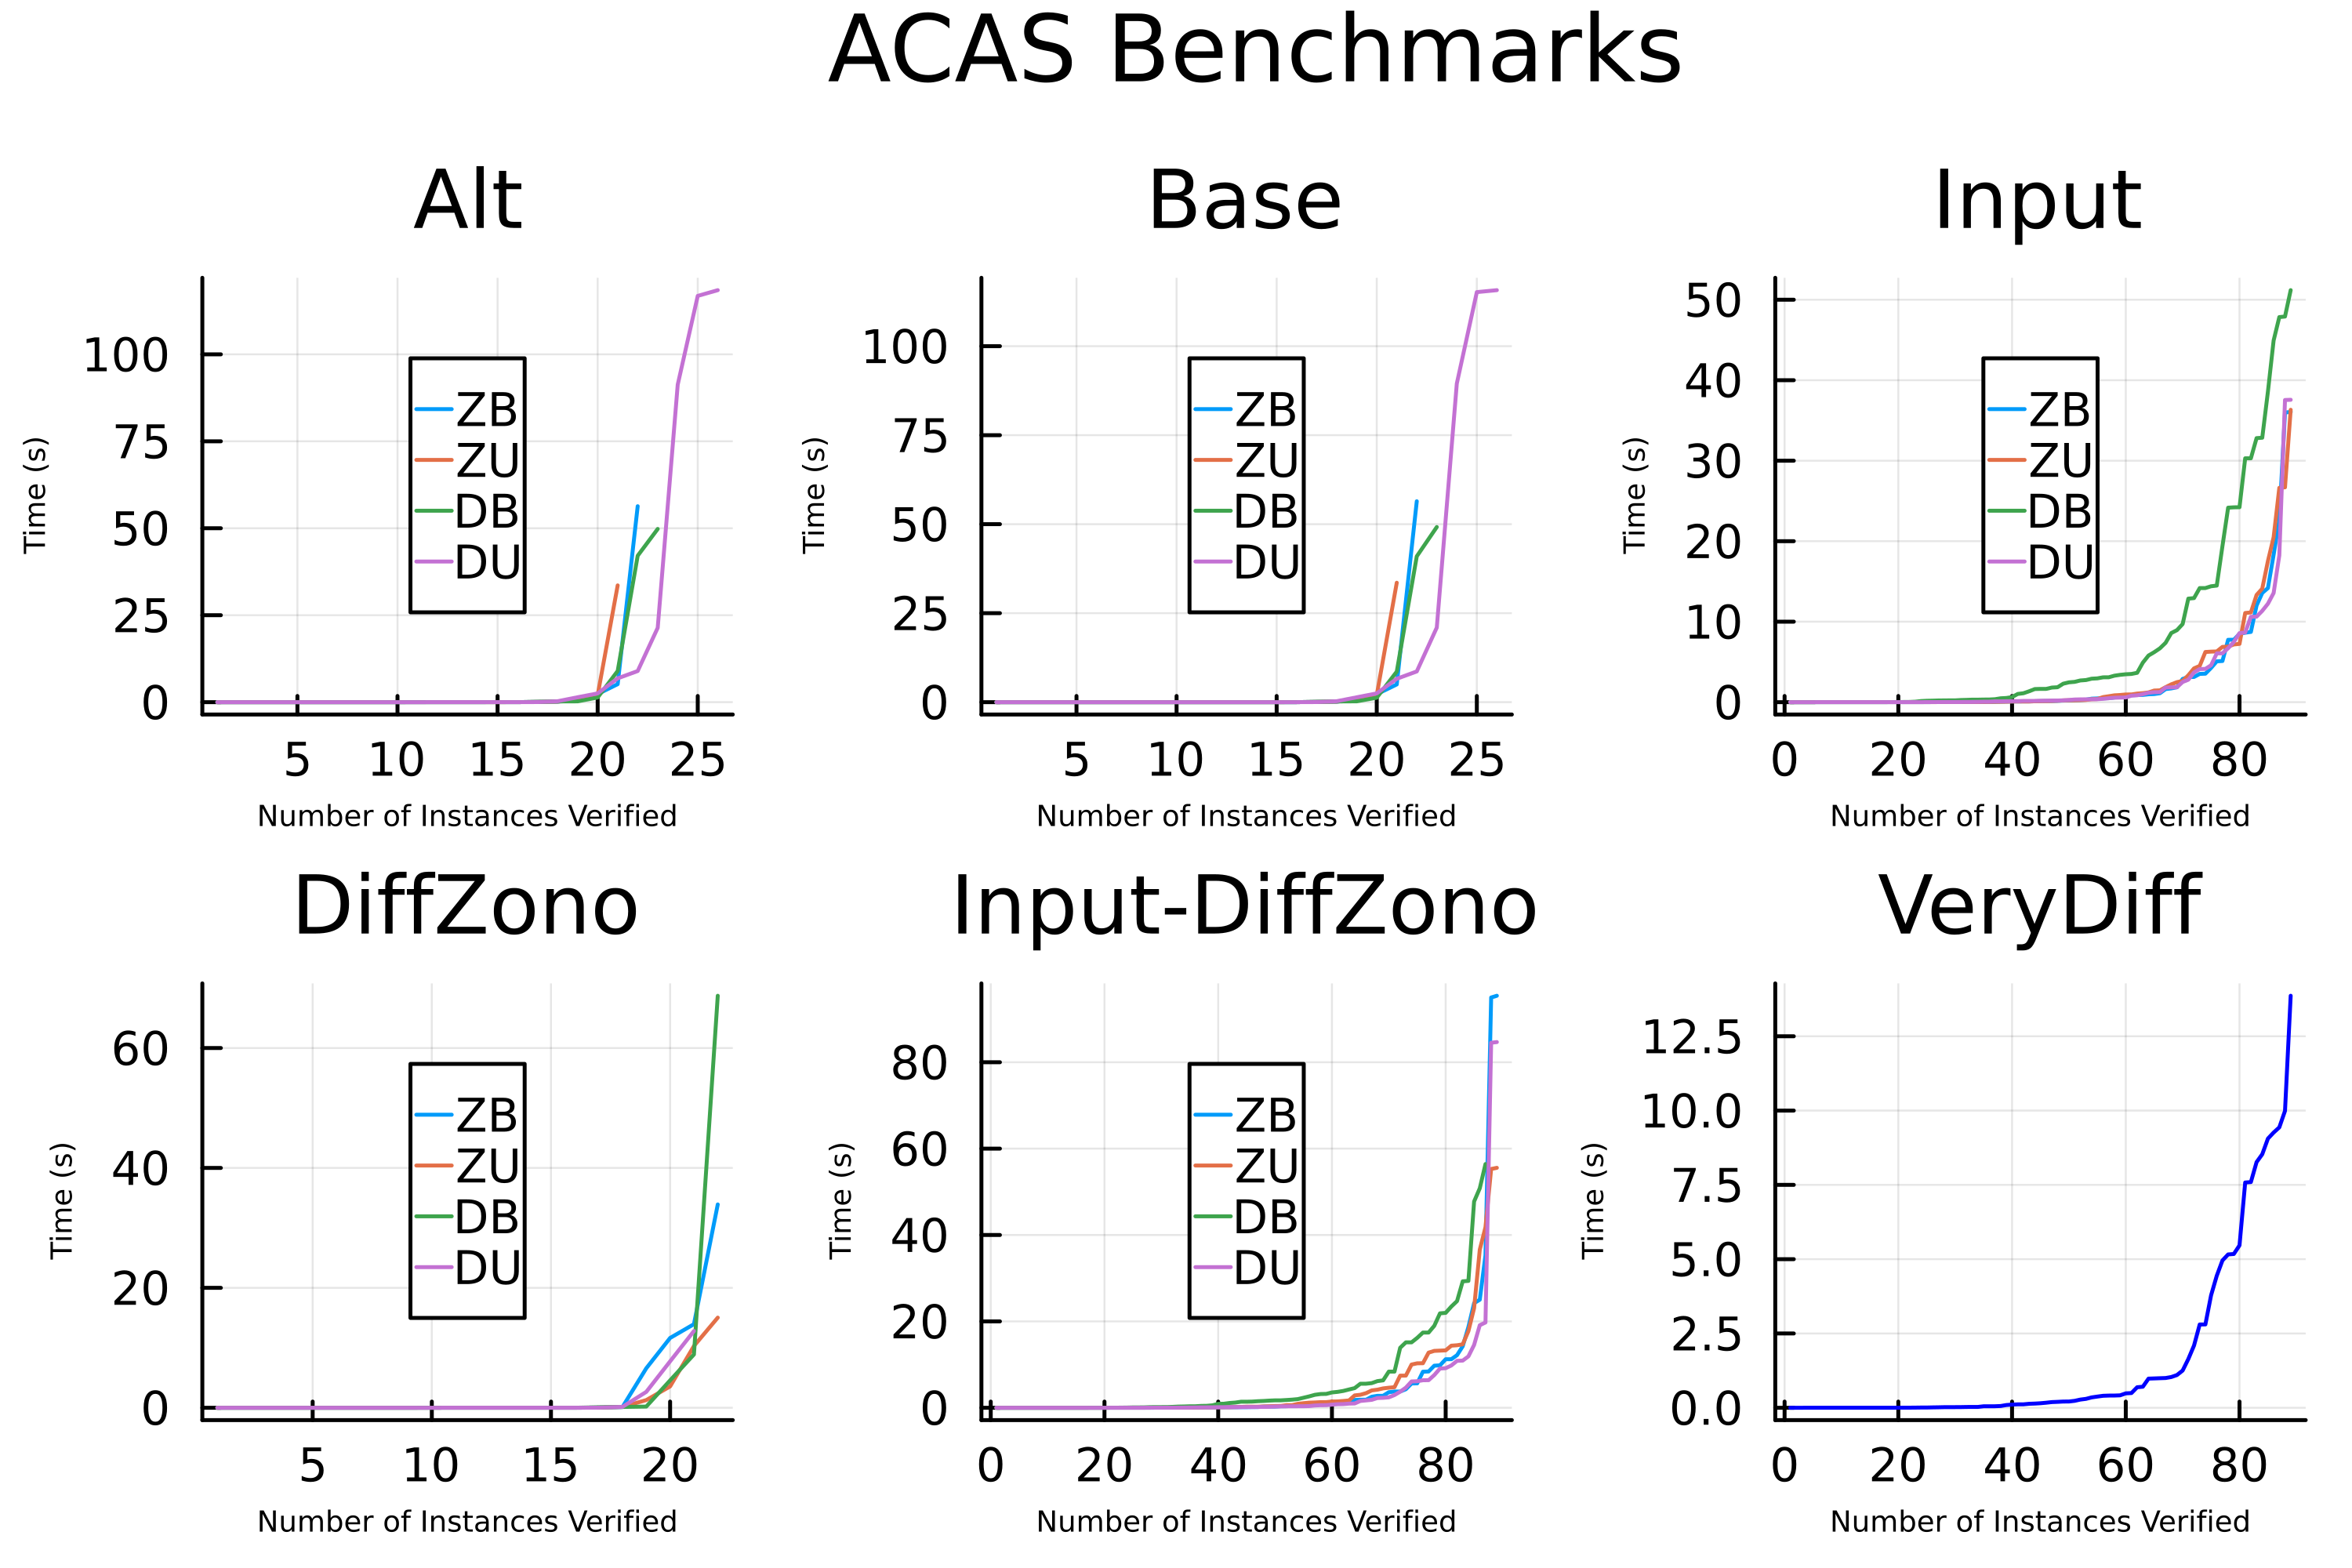

In [45]:
# gr(display_type=:inline)

p = plot(dpi=500, xguidefontsize=5, yguidefontsize=5, legend=:legend; layout=6)
xlabel!("Number of Instances Verified")
ylabel!("Time (s)")

verydiff_rgx = r"VeryDiff"
alt_rgx = r"((ZB|ZU|DB|DU)\-Alt$)"
base_rgx = r"((ZB|ZU|DB|DU)\-Base$)"
input_rgx = r"((ZB|ZU|DB|DU)\-Input$)"
diffzono_rgx = r"((ZB|ZU|DB|DU)\-DiffZono$)"
input_diffzono_rgx = r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"

indices = rgx -> filter(i -> !isnothing(findfirst(rgx, verifier_names[i])), 1:size(verifier_names, 1))

configs = [alt_rgx, base_rgx, input_rgx, diffzono_rgx, input_diffzono_rgx]

plot!(p, x_acas[indices(verydiff_rgx)], y_acas[indices(verydiff_rgx)], title="VeryDiff", lc=:blue, label=nothing, subplot=6)

for (i, rgx) in enumerate(configs)
    index = indices(rgx)
    plot!(p, x_acas[index], y_acas[index], title=heuristic_variants[2][i], label=["ZB" "ZU" "DB" "DU"], subplot=i)
end

plot!(p, plot_title="ACAS Benchmarks", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks.png")

p

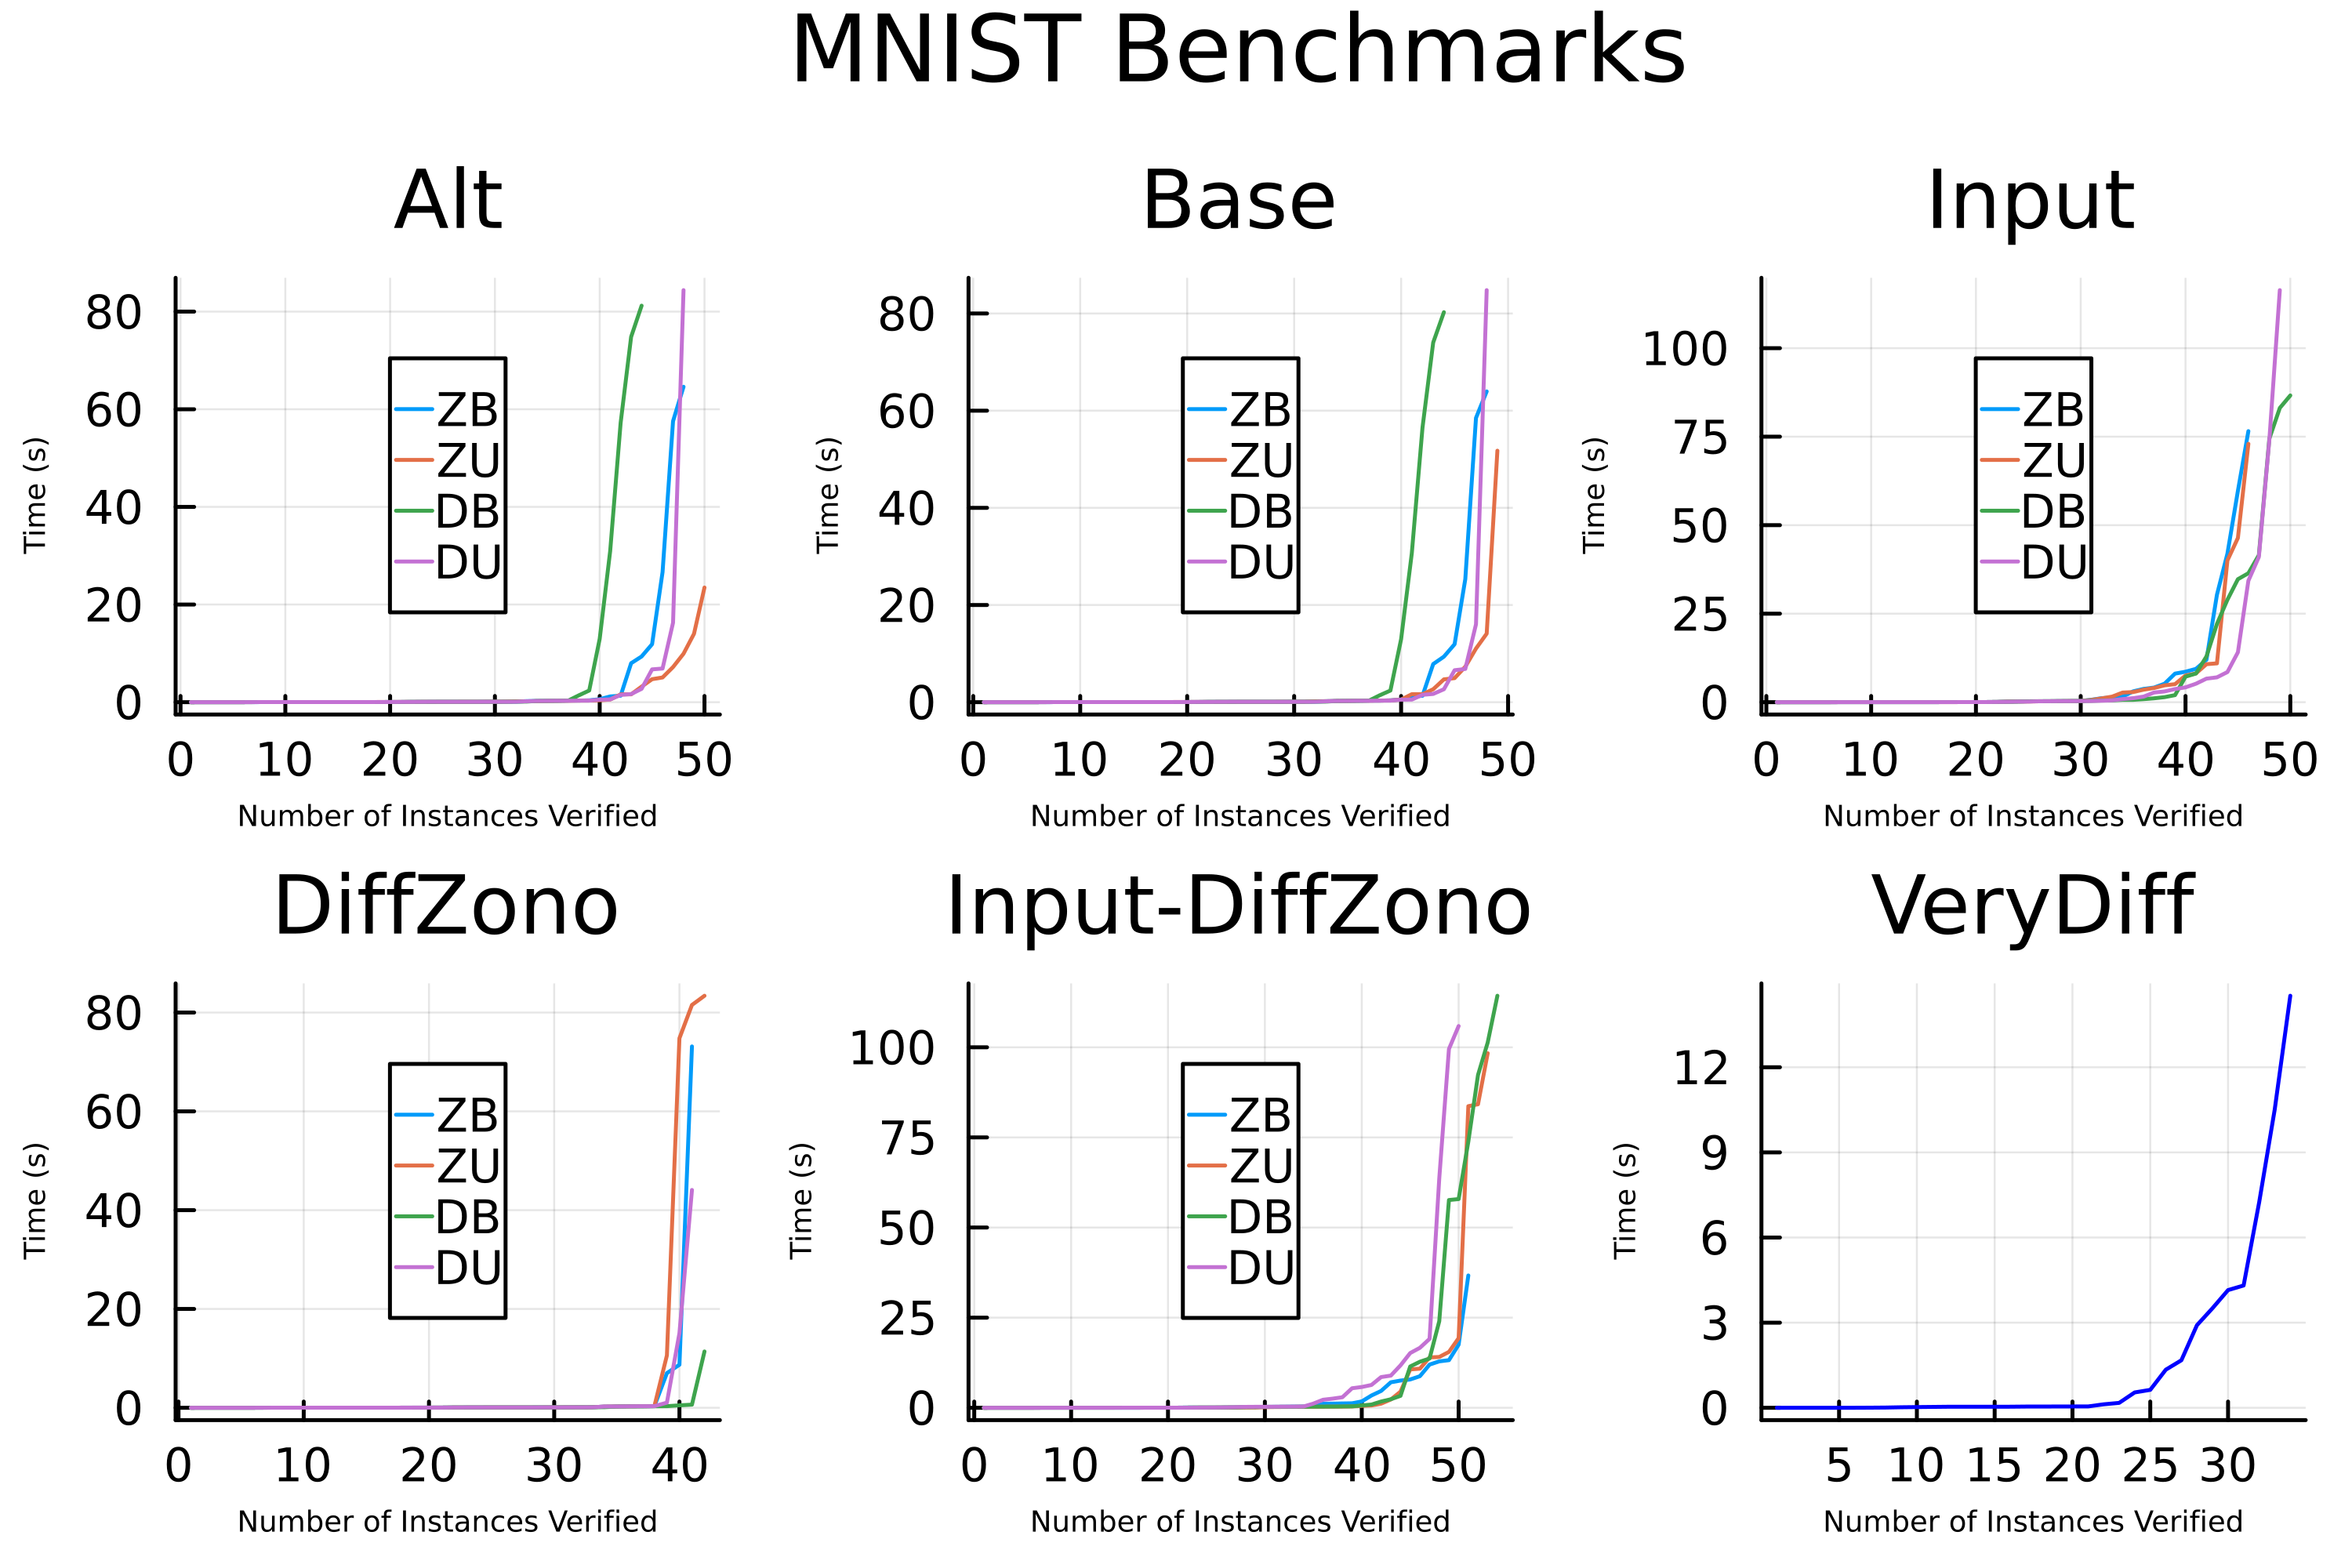

In [46]:
# gr(display_type=:inline)

p = plot(dpi=500, xguidefontsize=5, yguidefontsize=5, legend=:legend; layout=6)
xlabel!("Number of Instances Verified")
ylabel!("Time (s)")

verydiff_rgx = r"VeryDiff"
alt_rgx = r"((ZB|ZU|DB|DU)\-Alt$)"
base_rgx = r"((ZB|ZU|DB|DU)\-Base$)"
input_rgx = r"((ZB|ZU|DB|DU)\-Input$)"
diffzono_rgx = r"((ZB|ZU|DB|DU)\-DiffZono$)"
input_diffzono_rgx = r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"

indices = rgx -> filter(i -> !isnothing(findfirst(rgx, verifier_names[i])), 1:size(verifier_names, 1))

configs = [alt_rgx, base_rgx, input_rgx, diffzono_rgx, input_diffzono_rgx]

plot!(p, x_mnist[indices(verydiff_rgx)], y_mnist[indices(verydiff_rgx)], title="VeryDiff", lc=:blue, label=nothing, subplot=6)

for (i, rgx) in enumerate(configs)
    index = indices(rgx)
    plot!(p, x_mnist[index], y_mnist[index], title=heuristic_variants[2][i], label=["ZB" "ZU" "DB" "DU"], subplot=i)
end

plot!(p, plot_title="MNIST Benchmarks", plot_titlevspan=0.1)

savefig(p, "mnist_benchmarks_0.png")

p

In [ ]:
p = plot(dpi=400, xlabel="Number of Instances Verified", ylabel="Time (s)", legend=:legend, framestyle=:origin)

alt_rgx = r"((ZB|ZU|DB|DU)\-Alt$)"
base_rgx = r"((ZB|ZU|DB|DU)\-Base$)"
alt_vs_base_rgx = Regex(join([alt_rgx.pattern, base_rgx.pattern], "|"))
input_rgx = r"((ZB|ZU|DB|DU)\-Input$)"
diffzono_rgx = r"((ZB|ZU|DB|DU)\-DiffZono$)"
input_diffzono_rgx = r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"

indices = filter(i -> !isnothing(findfirst(alt_rgx, labels[i])), 1:size(labels, 1))

for i in indices
# for i in 1:size(y_acas, 1)
    plot!(p, x_acas[i], y_acas[i], label=verifier_names[i]; layout=(4, 4))
    # plot!(p, x_acas[i], y_acas[i], label=nothing)
end

# savefig(p, "acas_benchmarks.png")